# K2 Lightcurve Fitting with CARMA Models

In [1]:
push!(LOAD_PATH, "/Users/farr/Documents/Research/GaussianNoiseModeling/PopeFilters/code")

3-element Array{ByteString,1}:
 "/Users/farr/Documents/code/julia/usr/local/share/julia/site/v0.4"     
 "/Users/farr/Documents/code/julia/usr/share/julia/site/v0.4"           
 "/Users/farr/Documents/Research/GaussianNoiseModeling/PopeFilters/code"

In [2]:
using Ensemble
using Kalman
using PyCall
using PyPlot

In [3]:
@pyimport seaborn
seaborn.set_style("ticks")

## Data

In [68]:
name0 = "EPIC 211000411"
name9 = "EPIC 211098454"

"EPIC 211098454"

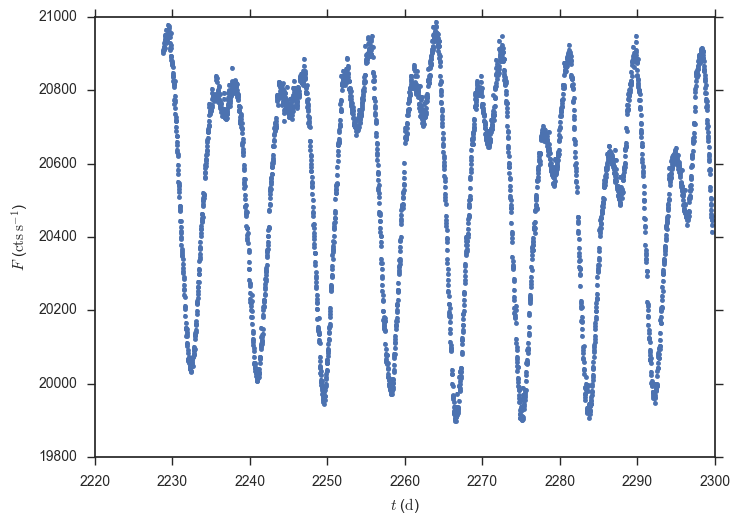

PyObject <matplotlib.text.Text object at 0x32554ff50>

In [7]:
lc0 = readdlm("epic211000411.txt")
errorbar(lc0[:,1], lc0[:,2], lc0[:,3], fmt=".")
xlabel(L"$t$ ($\mathrm{d}$)")
ylabel(L"$F$ ($\mathrm{cts} \, \mathrm{s}^{-1}$)")

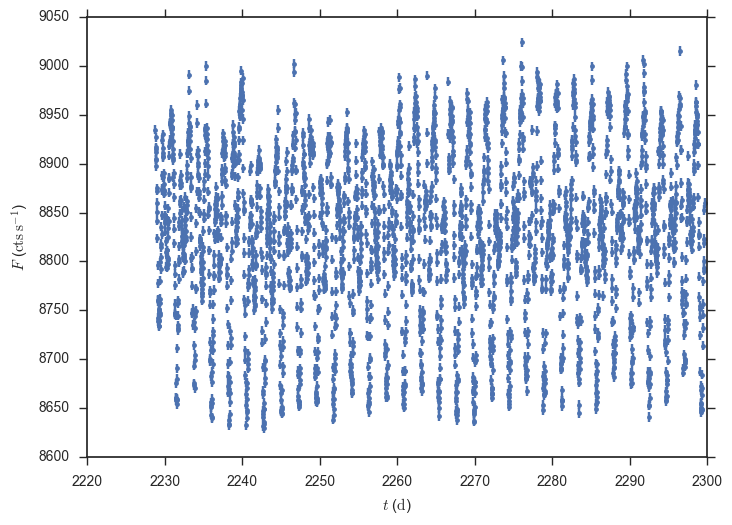

PyObject <matplotlib.text.Text object at 0x324c278d0>

In [6]:
lc9 = readdlm("epic211098454.txt")
errorbar(lc9[:,1], lc9[:,2], lc9[:,3], fmt=".")
xlabel(L"$t$ ($\mathrm{d}$)")
ylabel(L"$F$ ($\mathrm{cts} \, \mathrm{s}^{-1}$)")

## Simulations of $(5,4)$ CARMA Models

In [28]:
ns0 = open(deserialize, "epic211000411-CARMA/state-5-4.dat", "r")
ps0 = EnsembleNest.postsample(ns0)
nps0 = size(ps0, 2)
post0 = Kalman.CARMAKalmanPosterior(lc0[:,1], lc0[:,2], lc0[:,3], 5, 4)
size(ps0)

(12,7157)

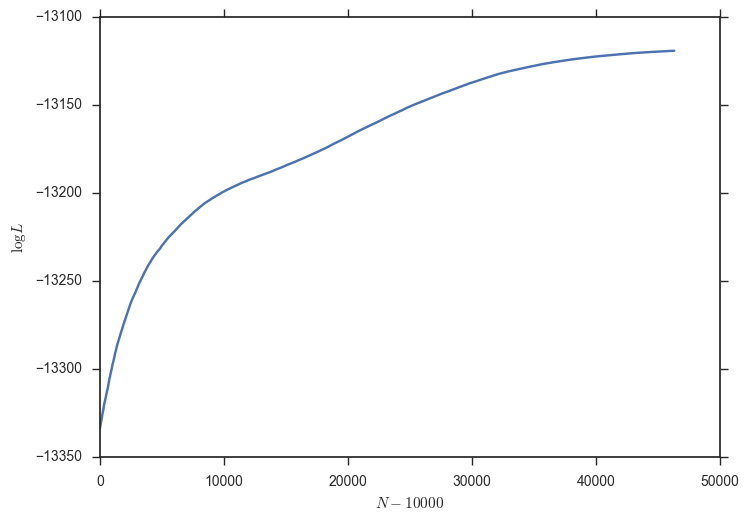

PyObject <matplotlib.text.Text object at 0x325746690>

In [10]:
plot(ns0.deadlogls[10000:end])
xlabel(L"$N-10000$")
ylabel(L"$\log L$")

In [29]:
ns9 = open(deserialize, "epic211098454-CARMA//state-5-4.dat", "r")
ps9 = EnsembleNest.postsample(ns9)
nps9 = size(ps9, 2)
post9 = Kalman.CARMAKalmanPosterior(lc9[:,1], lc9[:,2], lc9[:,3], 5, 4)
size(ps9)

(12,6381)

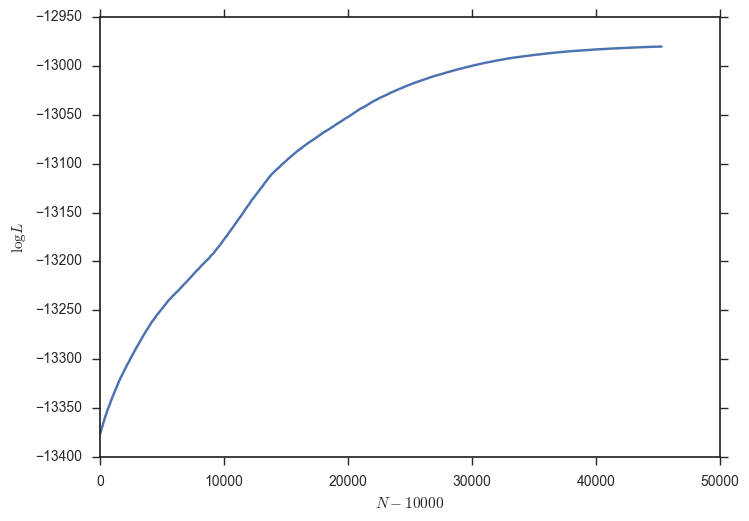

PyObject <matplotlib.text.Text object at 0x325c3e610>

In [12]:
plot(ns9.deadlogls[10000:end])
xlabel(L"$N-10000$")
ylabel(L"$\log L$")

## PSDs

In [15]:
fs0 = Kalman.psdfreq(post0)
fs9 = Kalman.psdfreq(post9)
psds0 = Kalman.psd(post0, ps0[:, rand(1:nps0, 1000)], fs0)
psds9 = Kalman.psd(post9, ps9[:, rand(1:nps9, 1000)], fs9)

1734x1000 Array{Float64,2}:
 254.009     344.184     224.599     …  308.52      151.528     261.888   
 254.086     344.253     224.708        308.502     151.517     261.896   
 254.217     344.374     224.893        308.478     151.5       261.912   
 254.409     344.556     225.159        308.452     151.48      261.943   
 254.67      344.812     225.515        308.436     151.459     261.995   
 255.012     345.158     225.971     …  308.442     151.441     262.08    
 255.448     345.617     226.54         308.486     151.431     262.211   
 255.996     346.216     227.239        308.589     151.436     262.405   
 256.68      346.988     228.09         308.776     151.464     262.682   
 257.527     347.976     229.118        309.077     151.525     263.069   
 258.572     349.23      230.356     …  309.53      151.631     263.597   
 259.855     350.815     231.844        310.18      151.799     264.305   
 261.431     352.808     233.632        311.084     152.048     265.241 

Plot the PSDs:

In [24]:
function plot_psd(fs, psd)
    nf = size(fs, 1)
    ns = size(psd, 2)

    m = zeros(nf)
    h = zeros(nf)
    l = zeros(nf)
    
    for i in 1:nf
        m[i] = median(vec(psd[i,:]))
        h[i] = quantile(vec(psd[i,:]), 0.84)
        l[i] = quantile(vec(psd[i,:]), 0.16)
    end
    
    plot(fs, m)
    fill_between(fs, h, l, alpha=0.5)
    xscale("log")
    yscale("log")
    xlabel(L"$f$ ($\mathrm{d}^{-1}$)")
    ylabel(L"$P(f)$ ($\mathrm{cts}^2 \, \mathrm{s}^{-2} \, \mathrm{d}$)")
end

plot_psd (generic function with 1 method)

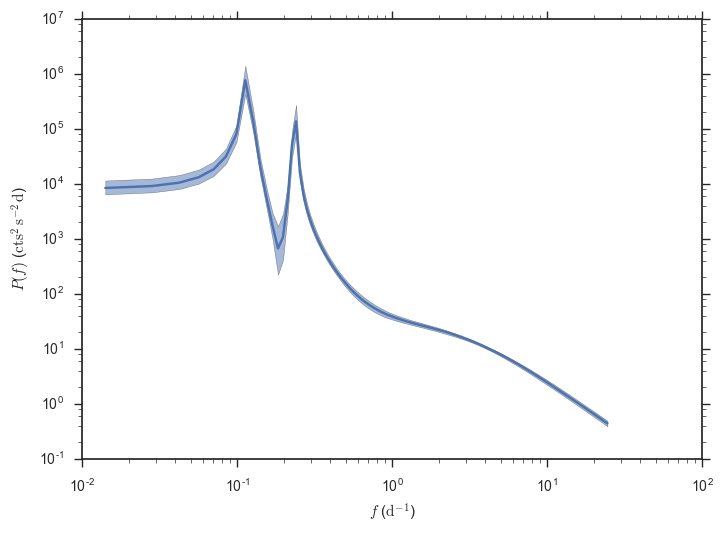

PyObject <matplotlib.text.Text object at 0x325be0790>

In [25]:
plot_psd(fs0, psds0)

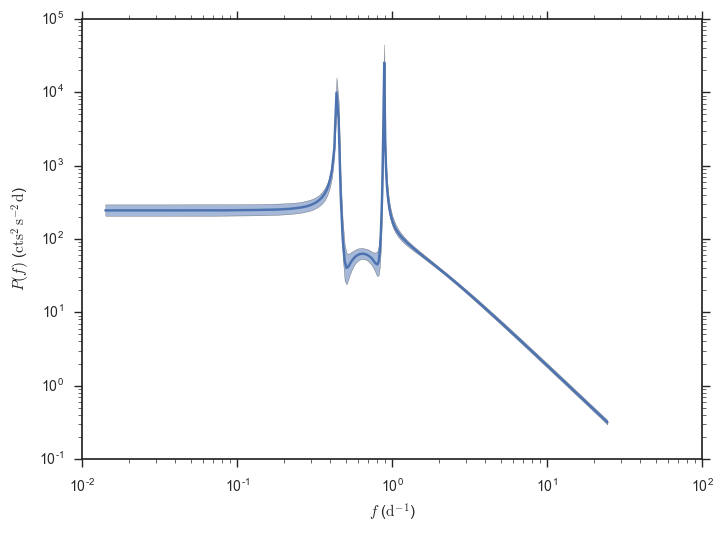

PyObject <matplotlib.text.Text object at 0x329a87690>

In [26]:
plot_psd(fs9, psds9)

## Minimum Frequency (Longest Period) Mode

We want to plot the longest period in the data (lowest frequency) for the two stars, the amplitude ratio of the two peaks that appear, and the period or frequency ratio.  For some reason, the seaborn KDE is giving us trouble here, so all the plots are histogram-only.

In [69]:
freqs0 = Kalman.frequencies(post0, ps0)
freqs9 = Kalman.frequencies(post9, ps9)
fmin0 = zeros(size(freqs0,2))
fmax0 = zeros(size(freqs0,2))
fmin9 = zeros(size(freqs9,2))
fmax9 = zeros(size(freqs9,2))
for i in 1:size(fmin0,1)
    fs = freqs0[:,i]
    fs = fs[fs .> 0]
    fmin0[i] = minimum(fs)
    fmax0[i] = maximum(fs)
end
for i in 1:size(fmin9,1)
    fs = freqs9[:,i]
    fs = fs[fs .> 0]
    fmin9[i] = minimum(fs)
    fmax9[i] = maximum(fs)
end

In [70]:
Pmax0 = 1.0./fmin0
Pmin0 = 1.0./fmax0
Pmax9 = 1.0./fmin9
Pmin9 = 1.0./fmax9

6381-element Array{Float64,1}:
 1.13275
 1.12927
 1.1265 
 1.13041
 1.13298
 1.12793
 1.12862
 1.12964
 1.1239 
 1.13231
 1.13314
 1.13159
 1.1275 
 ⋮      
 1.12819
 1.12872
 1.12939
 1.12759
 1.12923
 1.12787
 1.13036
 1.1277 
 1.12889
 1.12799
 1.12939
 1.1289 

Period of EPIC 211000411 = 8.577482529494379 +/- 0.16178168966398693 d


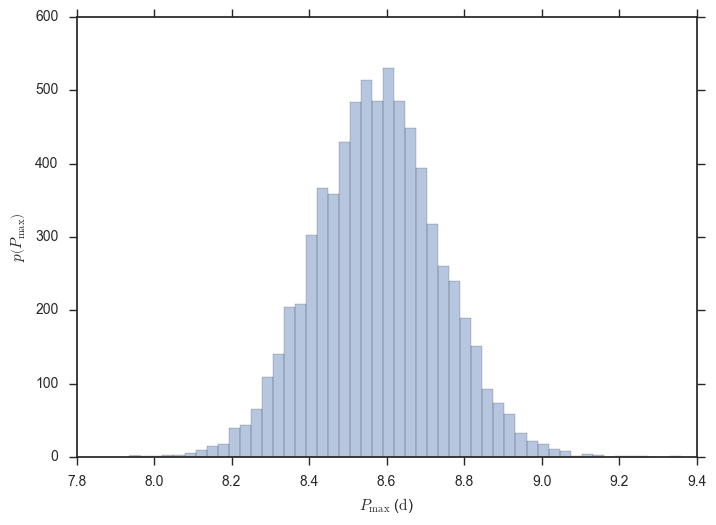

In [71]:
seaborn.distplot(Pmax0, kde=false) # Something weird about KDE range
xlabel(L"$P_\mathrm{max}$ ($\mathrm{d}$)")
ylabel(L"$p\left( P_\mathrm{max}\right)$")
println("Period of $name0 = $(mean(1.0./fmin0)) +/- $(std(1.0./fmin0)) d")

Period of EPIC 211098454 = 2.253338018142586 +/- 0.007435135839748366 d


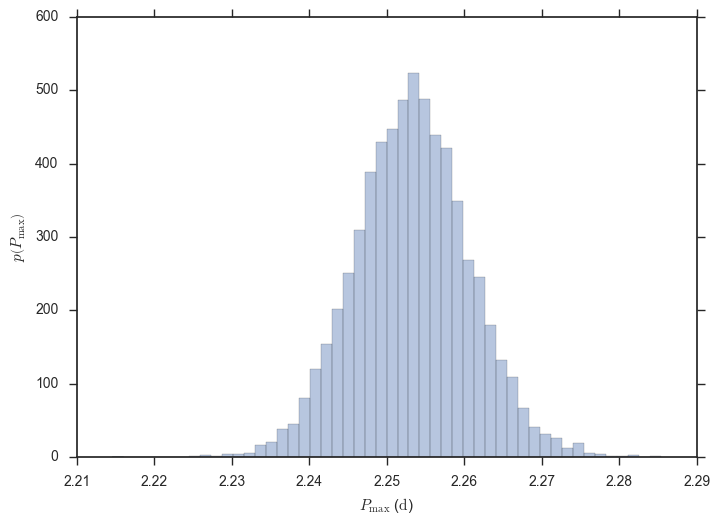

In [72]:
seaborn.distplot(Pmax9, kde=false) # Something weird about KDE range
xlabel(L"$P_\mathrm{max}$ ($\mathrm{d}$)")
ylabel(L"$p\left( P_\mathrm{max}\right)$")
println("Period of $name9 = $(mean(1.0./fmin9)) +/- $(std(1.0./fmin9)) d")

Note that the "9" period disagrees with the value given in `README`: it is a factor of two larger.  I'm not sure why the smaller period is quoted in the `README`, but maybe Suzanne reported the *stronger* of the two modes, no matter which one has larger periods?

## Period ratios

How about their ratio?

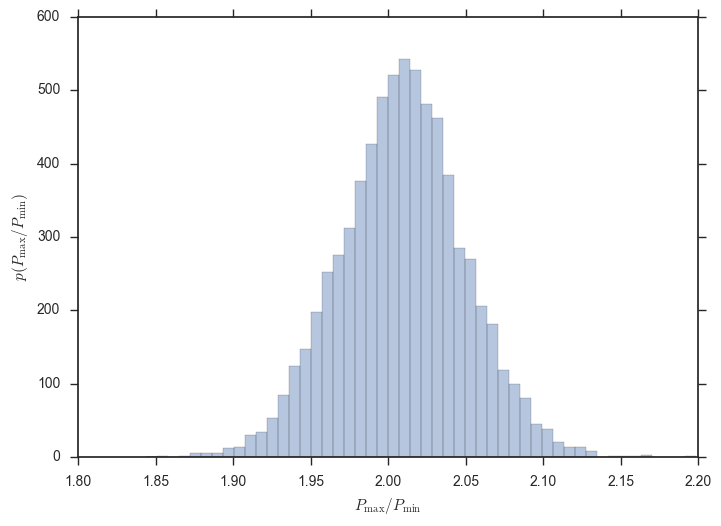

PyObject <matplotlib.text.Text object at 0x330c01190>

In [75]:
seaborn.distplot(Pmax0./Pmin0, kde=false)
xlabel(L"$P_\mathrm{max}/P_\mathrm{min}$")
ylabel(L"$p\left(P_\mathrm{max}/P_\mathrm{min}\right)$")

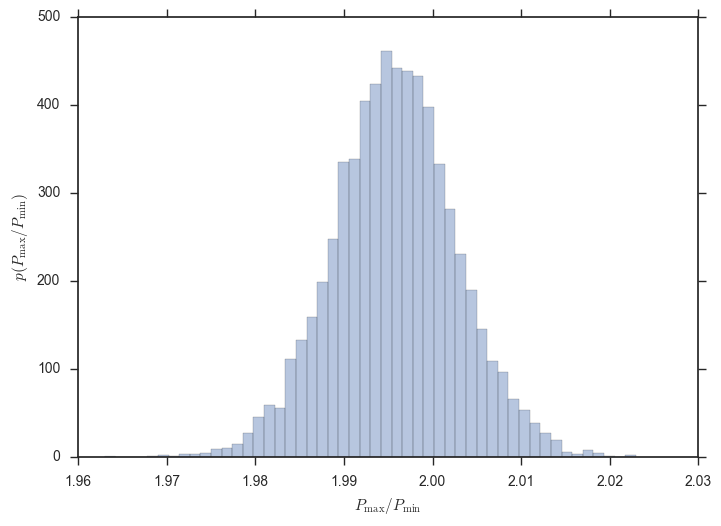

PyObject <matplotlib.text.Text object at 0x3308b2790>

In [76]:
seaborn.distplot(Pmax9./Pmin9, kde=false)
xlabel(L"$P_\mathrm{max}/P_\mathrm{min}$")
ylabel(L"$p\left(P_\mathrm{max}/P_\mathrm{min}\right)$")

In both systems we seem to have found the first and second harmonics of a signal....

## Decay Rate (Coherence Timescale)

In [79]:
drates0 = Kalman.drates(post0, ps0)
drates9 = Kalman.drates(post9, ps9)

5x6381 Array{Float64,2}:
 -0.0145028  -0.0232719  -0.0202249  …  -0.01426    -0.0143599  -0.0146723
 -0.0145028  -0.0232719  -0.0202249     -0.01426    -0.0143599  -0.0146723
 -0.0241225  -0.0268382  -0.0210112     -0.0143506  -0.0145093  -0.015965 
 -0.0241225  -0.0268382  -0.0210112     -0.0143506  -0.0145093  -0.015965 
 -5.17926    -6.8691     -5.73265       -6.46041    -5.9546     -6.30965  

In [82]:
drate_fund0 = zeros(size(drates0,2))
drate_fund9 = zeros(size(drates9,2))
drate_harm0 = zeros(size(drates0,2))
drate_harm9 = zeros(size(drates9,2))
for i in 1:size(drates0, 2)
    inds = sortperm(freqs0[:,i])
    drate_fund0[i] = drates0[inds[end-1],i] # Smallest (positive) freq decay rate
    drate_harm0[i] = drates0[inds[end],i] # Largest freq decay rate
end
for i in 1:size(drates9, 2)
    inds = sortperm(freqs9[:,i])
    drate_fund9[i] = drates9[inds[end-1],i]
    drate_harm9[i] = drates9[inds[end],i]
end

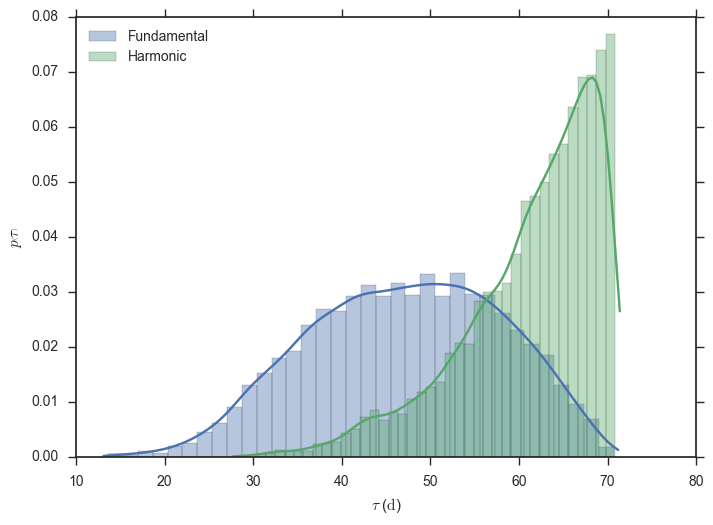

PyObject <matplotlib.legend.Legend object at 0x33107f4d0>

In [85]:
seaborn.distplot(-1.0./drate_fund0, label="Fundamental")
seaborn.distplot(-1.0./drate_harm0, label="Harmonic")
xlabel(L"$\tau$ ($\mathrm{d}$)")
ylabel(L"$p\left(\tau\right)$")
legend(loc="upper left")

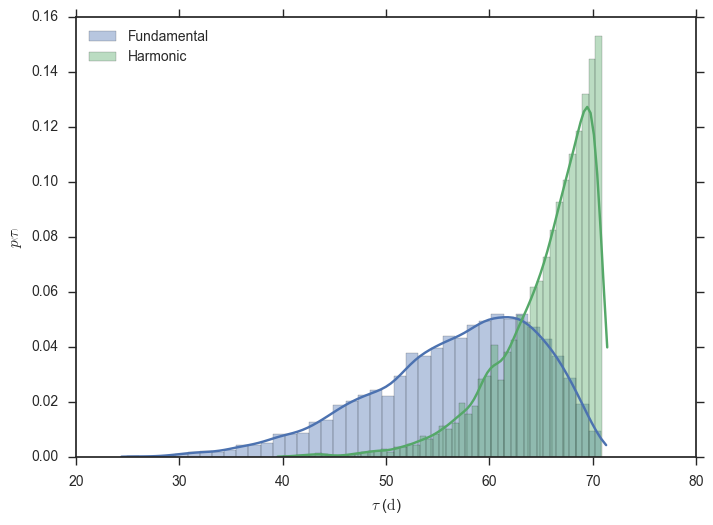

PyObject <matplotlib.legend.Legend object at 0x326c09a90>

In [86]:
seaborn.distplot(-1.0./drate_fund9, label="Fundamental")
seaborn.distplot(-1.0./drate_harm9, label="Harmonic")
xlabel(L"$\tau$ ($\mathrm{d}$)")
ylabel(L"$p\left(\tau\right)$")
legend(loc="upper left")

## Amplitude Ratios

TODO: Amplitude ratios!